# Problem 2: Convolutional Neural Networks (CNN)

In this assignment, you will develop a neural network with convolution and pooling layers to perform image classification, and test it out on the [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. 


### Import libraries including PyTorch

In [8]:
#Importing all libraries
import os
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import PIL
from PIL import Image
from torchvision import datasets

### Download the data

Without data augmentation

In [9]:

train_transform = transforms.Compose(
    [#transforms.RandomHorizontalFlip(p=0.5),
     #transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1), interpolation=PIL.Image.BILINEAR), ##DATA AUGMENTATION 
     transforms.ToTensor(),
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     transforms.Normalize((0.5,), (0.5,))
     ])

test_transform = transforms.Compose(
    [
     transforms.ToTensor(),
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     transforms.Normalize((0.5,), (0.5,))
     ])

dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False, num_workers=8)

test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=8)

classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Visualize 10 different classes of images in the training dataset

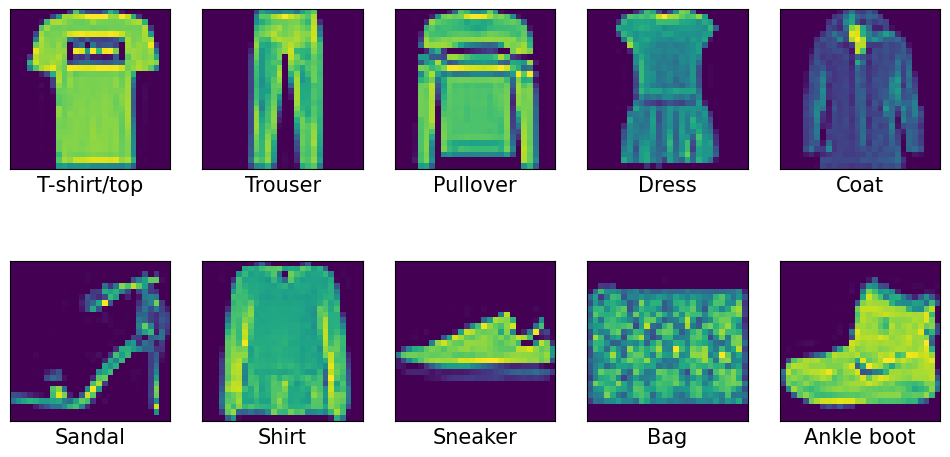

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# visualize training image for each class
sample_images = [dataset.data[np.asarray(dataset.targets) == label][0] for label in range(10)]
# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    axis.imshow(sample_images[i])
    i += 1

## 2.1. A CNN with MaxPooling layers



### Design the model 
You will implement a CNN model. In PyTorch, there are built-in functions that carry out the convolution steps for you. The following shows the key functions required for the design.


*   nn.**[Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)**(in_channels, out_channels, kernel_size, stride=1, padding=0, bias=False): Convolution layer.
*   nn.**[MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)**(kernel_size, stride=None, padding=0): Max pooling layer. 
* nn.**[Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)**(p=0.5, inplace=False): randomly zeroes some of the elements of the input tensor during training.
*   F.**[relu](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)**(Z1): computes the elementwise ReLU of Z1 (which can be any shape).  
*   x.**[view](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html)**(new_shape): returns a new tensor with the same data but different size. It is the equivalent of numpy function reshape (Gives a new shape to an array without changing its data). 
*   nn.**[Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)**(in_features, out_features): applies a linear transformation to the incoming data. It is also called a fully connected layer. 

In [11]:
import torch.nn as nn
import torch.nn.functional as F

# Problem 2: Implementing your own CNN
# a. Convolution and MaxPooling layers


class CNN_Max(nn.Module):
  """
  A convolutional neural network (CNN). In this CNN object, we will use following
  dimensions:

  input_size: the dimension d of the input data.                        
  hidden_size: the number of neurons h in the hidden layer.             
  output_size: the number of classes c, which is 10 in our task          
  """
  def __init__(self):
    """
    An initialization function. This object of network is a simple feed-forward 
    network. It takes an input to pass to muitiple layers. Then, provide the 
    output. The layers are initialized after their creation. 

    In this problem, we will use following set of parameters building a CNN/

    conv: convolutional kernel size, which is 3 by 3 with bias                         
    pool: pooling kernel-size, which is 2 by 2    
    dropout: random zeroing layer with probability 0.4                            
    fc: fully-connected layer which uses affine operation y=Wx+b              

    Parameters
    ----------
    N/A
    """
    super(CNN_Max, self).__init__()

    #############################################################################
    # PLACE YOUR CODE HERE                                                      #
    ############################################################################# 

    self.conv_32 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, bias=True)
    self.bn_32 = nn.BatchNorm2d(32)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=1)
    self.conv_64 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, bias=True)
    self.bn_64 = nn.BatchNorm2d(64)

    self.linear_64 = nn.Linear(in_features=64 * 22 * 22, out_features=64)
    self.linear_bn_64 = nn.BatchNorm1d(64)
    self.linear_32 = nn.Linear(in_features=64, out_features=32)
    self.linear_bn_32 = nn.BatchNorm1d(32)
    self.linear_10 = nn.Linear(in_features=32, out_features=10)

    self.dropout_05 = nn.Dropout(p=0.5)
    self.dropout_02 = nn.Dropout(p=0.5)


    #############################################################################
   

  def forward(self, x):
    """
    A forward pass function. Using the pre-defined network modules, we can here 
    build a model designing its structure. 

    Parameters
    ---------- 
    x: matrix  
      an input data of shape (1, d, d), where d is the dimension of the input 
      image. 
  
    Returns
    ---------- 
    out:     
      an output data given x.

    """
    #############################################################################
    # PLACE YOUR CODE HERE                                                      #
    ############################################################################# 
    out = self.conv_32(x)
    out = self.bn_32(out)
    out = F.relu(out)
    out = self.pool(out)
    #out = self.dropout_02(out)

    out = self.conv_64(out)
    out = self.bn_64(out)
    out = F.relu(out)
    out = self.pool(out)
    #out = self.dropout_02(out)

    out = out.view(-1, 64 * 22 * 22)

    out = F.relu(self.linear_64(out))
    out = self.linear_bn_64(out)
    out = self.dropout_05(out)
    out = F.relu(self.linear_32(out))
    out = self.linear_bn_32(out)
    out = self.dropout_05(out)
    out = self.linear_10(out)

    #############################################################################

    return out

# create a CNN object
net = CNN_Max()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)
net.to(device)

num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Number of trainable parameters:", num_params)

from torchsummary import summary
summary(net,(1,28,28))

Device: cuda:0
Number of trainable parameters: 2004138
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
       BatchNorm2d-2           [-1, 32, 26, 26]              64
         MaxPool2d-3           [-1, 32, 25, 25]               0
            Conv2d-4           [-1, 64, 23, 23]          18,496
       BatchNorm2d-5           [-1, 64, 23, 23]             128
         MaxPool2d-6           [-1, 64, 22, 22]               0
            Linear-7                   [-1, 64]       1,982,528
       BatchNorm1d-8                   [-1, 64]             128
           Dropout-9                   [-1, 64]               0
           Linear-10                   [-1, 32]           2,080
      BatchNorm1d-11                   [-1, 32]              64
          Dropout-12                   [-1, 32]               0
           Linear-13                   [-1, 10] 

### Train the designed model:

In [12]:
import torch.optim as optim

"""

 You have to define the loss, for that please use cross entropy loss      
 Also, you must implement optimizer called SGD.                           

"""

#############################################################################
# PLACE YOUR CODE HERE                                                      #
############################################################################# 

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
 
#############################################################################
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

loss_hist, acc_hist = [], []
loss_hist_val, acc_hist_val = [], []

for epoch in range(30):
  running_loss = 0.0
  correct = 0
  for data in train_loader:
    batch, labels = data
    batch, labels = batch.to(device), labels.to(device)

    """

    First, set the gradients to zero. Then obtain predictions from your CNN   
    model. After that, pass into loss to calculate the difference between the 
    prediction and labels. Next, you have to compute the gradients with       
    respect to the tensor.  


    """
    #############################################################################
    # PLACE YOUR CODE HERE                                                      #
    ############################################################################# 
    optimizer.zero_grad()
    outputs = net(batch)
    loss = criterion(outputs, labels)
    loss.backward()


 
    #############################################################################
    optimizer.step()

    # compute training statistics
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    running_loss += loss.item()

  avg_loss = running_loss / len(train_set)
  avg_acc = correct / len(train_set)
  loss_hist.append(avg_loss)
  acc_hist.append(avg_acc)

  # validation statistics
  net.eval()
  with torch.no_grad():
    loss_val = 0.0
    correct_val = 0
    for data in val_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      outputs = net(batch)
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct_val += (predicted == labels).sum().item()
      loss_val += loss.item()
    avg_loss_val = loss_val / len(val_set)
    avg_acc_val = correct_val / len(val_set)
    loss_hist_val.append(avg_loss_val)
    acc_hist_val.append(avg_acc_val)
  net.train()

  scheduler.step(avg_loss_val)
  print('[epoch %d] loss: %.5f accuracy: %.4f val loss: %.5f val accuracy: %.4f' % (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val))

[epoch 1] loss: 0.00592 accuracy: 0.7456 val loss: 0.00323 val accuracy: 0.8533
[epoch 2] loss: 0.00381 accuracy: 0.8389 val loss: 0.00258 val accuracy: 0.8826
[epoch 3] loss: 0.00332 accuracy: 0.8599 val loss: 0.00230 val accuracy: 0.8950
[epoch 4] loss: 0.00303 accuracy: 0.8736 val loss: 0.00232 val accuracy: 0.8984
[epoch 5] loss: 0.00283 accuracy: 0.8837 val loss: 0.00213 val accuracy: 0.9050
[epoch 6] loss: 0.00264 accuracy: 0.8892 val loss: 0.00203 val accuracy: 0.9086
[epoch 7] loss: 0.00251 accuracy: 0.8949 val loss: 0.00199 val accuracy: 0.9101
[epoch 8] loss: 0.00238 accuracy: 0.8992 val loss: 0.00201 val accuracy: 0.9105
[epoch 9] loss: 0.00227 accuracy: 0.9056 val loss: 0.00197 val accuracy: 0.9120
[epoch 10] loss: 0.00219 accuracy: 0.9084 val loss: 0.00195 val accuracy: 0.9157
[epoch 11] loss: 0.00209 accuracy: 0.9128 val loss: 0.00195 val accuracy: 0.9166
[epoch 12] loss: 0.00206 accuracy: 0.9142 val loss: 0.00194 val accuracy: 0.9162
[epoch 13] loss: 0.00195 accuracy: 0.

### Visualize the classification accuracies

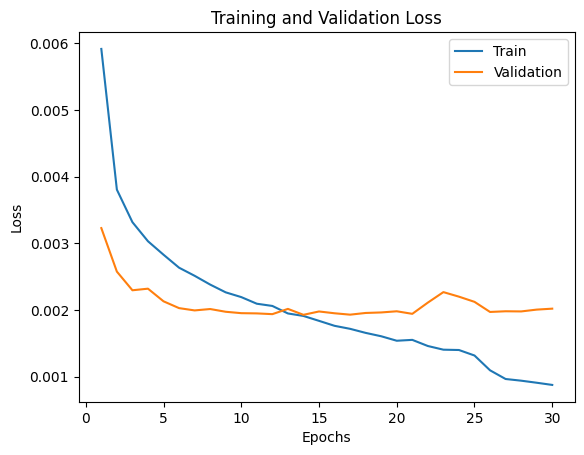

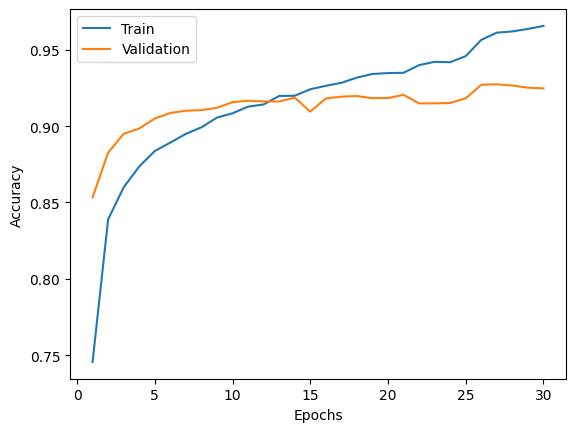

In [13]:
import matplotlib.pyplot as plt

"""

  You have to plot two graphs, one for loss of training and validation data 
  and second one for accuarcy of training and validation data.              
  Set x-axis to number of epochs and y-axis to loss or accuracy. Set legend 
  equal to training and validation set.                                      

"""
legend = ['Train', 'Validation']
#############################################################################
# PLACE YOUR CODE HERE                                                      #
############################################################################# 


 # Number of epochs
epochs = range(1, len(loss_hist) + 1)

# Plot the loss graph
plt.figure()
plt.plot(epochs, loss_hist, label='Train')
plt.plot(epochs, loss_hist_val, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Plot the accuracy graph
plt.figure()
plt.plot(epochs, acc_hist, label='Train')
plt.plot(epochs, acc_hist_val, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')



 
#############################################################################
plt.legend(legend, loc='upper left')
plt.show()


Save and download the learned weights

In [7]:
from google.colab import files

torch.save(net.state_dict(), 'checkpoint.pth')
# download checkpoint file
files.download('checkpoint.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Test the learned model with the test dataset

In [14]:
pred_vec = []
correct = 0
net.eval()
with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = net(batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec.append(predicted)
    pred_vec = torch.cat(pred_vec)

print('Accuracy on the 10000 test images: %.2f %%' % (100 * correct / len(test_set)))

Accuracy on the 10000 test images: 92.77 %
